[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ba-minor/OR_OWRD_OSU_training/blob/main/notebooks/et_cu_data_retrieval_gee.ipynb)

# <span style="color:green">Oregon Hydrographic Area Historical ET & Consumptive Use Geodatabase: OWRD, DRI, and OpenET</span>

<center><img src="https://github.com/ba-minor/OR_OWRD_OSU_training/blob/main/notebooks/data_viz_et.png?raw=1" width="900"/></center>
<!-- ![Data Viz](data_viz_et.png "ET/CU Geodatabase") -->

______________________
<br>


# ET/CU field-level data visualization & retrieval [tool](https://dri-apps.projects.earthengine.app/view/owrd-oregon-etcu-field-summaries)
> Retrieve monthly/annual timeseries data for individual field boundaries for 1985-2024

<center><img src="https://github.com/ba-minor/OR_OWRD_OSU_training/blob/main/notebooks/data_viz_field_level_tool.png?raw=1" width="1200"/></center>

<br>

# Google Earth Engine/Python-based ET/CU data aggregation notebook
> Python and Google Earth Engine (GEE) workflow to summarize 40 years (1985-2024) of monthly/annual data variables for watersheds, irrigation districts, or user-drawn boundaries

## Data Variable Definitions:
* OpenET ensemble actual ET ($ET_{a}$)
* Bias-corrected gridMET reference ET ($ET_{o}$)
* Effective precipitation ($P_{rz}$)
* Total precipitation (PPT)
* Crop-specific potential ET ($ET_{c}$)
* Consumptive use (CU)
* Net irrigation water requirement (NIWR)
* Applied water (AW)


## <span style="color:red">Please run this notebook in Google Colab. You can use the icon at the top of the notebook to open the Colab session</span>

## **INTRODUCTION**
### Google Workspace - Requirement
Online productivity and collaboration tools for businesses and individuals. Google Workspace includes services like Gmail, Google Drive, Google Docs, Slides, Google Meet, and Google **Colab**, which allow users to collaborate, communicate, and store files in the cloud.
### What is Google Colab?
Colab is a hosted Jupyter Notebook service that requires no setup to use and provides free access to computing resources, including GPUs and TPUs. Colab is especially well suited to machine learning, data science, and education. Because all the processing happens on Google's servers, you can use Colab on any device without installing anything on your computer.<br><br>
### Earth Engine Access
"To use Earth Engine, you need access either via a Google Cloud project that's registered to use Earth Engine or via an individually signed-up account."
[Register](https://code.earthengine.google.com/register) and
[Guide](https://developers.google.com/earth-engine/guides/access)<br>
> NOTE: All Earth Engine users now need to use a Google Cloud project to access Earth Engine.
### Earth Engine JavaScript Playground versus Python API
> The [Earth Engine JavaScript Playground](https://code.earthengine.google.com/) is a coding environment/user interface that enables quick interactions with Earth Engine objects, the Data Catalog, and the suite of functions/tools to process raster and vector datasets without having to install libraries or prepare coding environments. [Beginner's Cookbook](https://developers.google.com/earth-engine/tutorials/community/beginners-cookbook)<br><br>
> The [Python Application Programming Interface (API)](https://developers.google.com/earth-engine/guides/python_install) is another way to use Earth Engine, which has improved functionality and enables you to link to other tools like geemap, pandas, geopandas, polars, and other Python packages.
<br>
### geemap
> [geemap](https://geemap.org/) is a python-based interactive geospatial analysis and visualization with Google Earth Engine.

___

# Overview of Walkthrough:

INTRODUCTION_________________________________

1. Earth Engine Data Catalog and the Awesome GEE Community Catalog
2. Installing and importing Python/Earth Engine packages

TIMESERIES EXPORT_____________________________

3. Export spatially and temporally aggregated ET/CU data

DATA COMPARISON______________________________

4. Compare applied water estimates to total diversions for Tumalo Irrigation District
> monthly & annual plotting, canal diversion comparisons, and conveyance loss estimates

___
<br><br>

# 1. Earth Engine Data Catalog and the Awesome GEE Community Catalog
## Access (and contribute!) meteorological, land cover, remote sensing, OpenET, hydrology, elevation, soils datasets, etc.
## [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog)<br>
## [Awesome GEE Community Catalog](https://gee-community-catalog.org/)<br><br>

## Getting started

In the Earth Engine Data Catalog, datasets can be of different types:

- *Features* which are geometric objects with a list of properties. For example, a watershed with some properties such as *name* and *area*, is an `ee.Feature`.
- *Images* which are like features, but may include several bands. For example, the ground elevation given by the USGS [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) is an `ee.Image`.
- *Collections* which are groups of features or images. For example, the [HUC10: USGS Watershed Boundary Dataset of Watersheds](https://developers.google.com/earth-engine/datasets/catalog/USGS_WBD_2017_HUC10) is a `ee.FeatureCollection` and the [OpenET CONUS Ensemble Monthly Evapotranspiration v2.0](https://developers.google.com/earth-engine/datasets/catalog/OpenET_ENSEMBLE_CONUS_GRIDMET_MONTHLY_v2_0) dataset is an `ee.ImageCollection`.

If you want to know more about different data models, you may want to visit the [Earth Engine User Guide](https://developers.google.com/earth-engine/guides).

# 2. Install/import Python packages and initialize the API

In [1]:
# need to install pycrs so we can upload shapefiles
%pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=9a532a4d0c149680729f0a90870d4fc95ff10b6d1cf09b205fb143865415a25d
  Stored in directory: /root/.cache/pip/wheels/b5/4a/72/1ba05f57ddf2cc80ad21a26512097762561d646ff3ff85f729
Successfully built pycrs


## Initialize the API and import packages
### First, set up your [Earth Engine enabled Cloud project](https://developers.google.com/earth-engine/guides/access)
### Authenticate your Google Cloud account after creating the Cloud project. Additional information about authentication and initialization [here](https://developers.google.com/earth-engine/guides/auth)


In [2]:
from google.colab import auth

GCLOUD_PROJECT_ID = "ee-eastnep07"  # @param {type:"string"}

auth.authenticate_user(project_id=GCLOUD_PROJECT_ID)

### Import Earth Engine, additional Python packages, and initialize the API

In [3]:
# Earth Engine Python package
import ee

# data wrangling
import pandas as pd
import numpy as np
import datetime

# geemap Python package to visualize Earth Engine objects
import geemap
import pycrs

# requests module for downloading data
import requests

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

# Initialize the library with your specified Google Cloud project name
ee.Initialize(project=GCLOUD_PROJECT_ID)

# 3. Export spatially aggregated monthly ET/CU data

In [7]:

# 1985-2024 ETCU stats data tables (shifted water year months and annual totals, Nov-Oct)
monthly_data_tab1 = ee.FeatureCollection('projects/ee-bminor/assets/OR/StatewideET/etcu_data_tables/oregon_field_monthly_summary_1985_1994')
monthly_data_tab2 = ee.FeatureCollection('projects/ee-bminor/assets/OR/StatewideET/etcu_data_tables/oregon_field_monthly_summary_1995_2004')
monthly_data_tab3 = ee.FeatureCollection('projects/ee-bminor/assets/OR/StatewideET/etcu_data_tables/oregon_field_monthly_summary_2005_2014')
monthly_data_tab4 = ee.FeatureCollection('projects/ee-bminor/assets/OR/StatewideET/etcu_data_tables/oregon_field_monthly_summary_2015_2024')

# merge each subset
monthly_data_tab = monthly_data_tab1.merge(monthly_data_tab2).merge(monthly_data_tab3).merge(monthly_data_tab4)

# annual table is separate
annual_data_tab = ee.FeatureCollection('projects/ee-bminor/assets/OR/StatewideET/etcu_data_tables/oregon_field_annual_summary')

# 1985-2024 ETCU stats feature collection (shifted water year months and annual totals, Nov-Oct)
fc_pre = ee.FeatureCollection('projects/ee-bminor/assets/OR/StatewideET/etcu_data_tables/oregon_field_mean_annual_fc').select(['OPENET_ID'])
fc_pre.limit(5)


In [9]:
fc_pre.first().getInfo()


{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-124.00144834476669, 46.32083509107778],
    [-124.00127837897, 46.32069270810471],
    [-124.00086591933761, 46.3205931833384],
    [-123.99935842002691, 46.32082537980198],
    [-123.99789771176043, 46.32119022001131],
    [-123.9975809752513, 46.32138721526145],
    [-123.99725746209202, 46.32178992979326],
    [-123.99667971200363, 46.32214650790208],
    [-123.99709171120561, 46.32213438854082],
    [-124.00003625008937, 46.32125657132293],
    [-124.00132248242043, 46.32099071999865],
    [-124.00144834476669, 46.32083509107778]]]},
 'id': '00000000000000001030',
 'properties': {'OPENET_ID': 'ORx_212595'}}

## Access the geodatabase data tables and feature collection

## Specify how the data is spatially & temporally aggregated

### Spatial Aggregation Type
1. <span style="color:limegreen">**draw**</span> - Draw a rectangle or polygon
2. <span style="color:turquoise">**upload**</span> - Upload a shapefile containing a region (e.g., irrigation district boundary)  
3. <span style="color:orange">**watershed**</span> - Use a watershed (i.e., HUC) boundary (must specify the HUC-level below and then run the cell)


### Timestep
1. <span style="color:violet">**monthly**</span>
2. <span style="color:gold">**annual**</span>


In [11]:
# -------------------------------------

spatial_aggregation_type = 'upload' # @param ['draw', 'upload', 'watershed']

timestep = 'monthly' # @param ['monthly', 'annual']

# -------------------------------------

if spatial_aggregation_type == 'draw':
    print('draw a rectangle or polygon on the map below to select field boundaries')

elif spatial_aggregation_type == 'upload':
    print('please upload your shapefile to the Google Colab and then specify the shapefile name in the next code block before running the cell')

elif spatial_aggregation_type == 'watershed':
    print('please specify the watershed type (i.e., HUC level) in the next code block and then run the cell')

please upload your shapefile to the Google Colab and then specify the shapefile name in the next code block before running the cell


In [13]:
if spatial_aggregation_type == 'upload':

    # name of the uploaded shapefile (the example uses Tumalo Irrigation District boundary shapefile, which is uploaded from GitHub automatically)
    shapefile_name = 'fifteen_eight_study_aoi' # @param {type: 'string'}

    if shapefile_name == 'fifteen_eight_study_aoi':
        try:
            # cloning github repo for Tumalo Irrigation District diversion example
            !git clone https://github.com/mmehata2023/fifteen
        except Exception as e:
            print(e)

    print(f"Using shapefile named '{shapefile_name}' to aggregate the data")

elif spatial_aggregation_type == 'watershed':

    # HUC level to use for aggregating the data
    huc_type = 'HUC10' # @param ['HUC08', 'HUC10', 'HUC12']

    # HUC feature collection assetID naming convention is different than the watershed feature properties
    huc_dict = {
        'HUC08': 'huc8',
        'HUC10': 'huc10',
        'HUC12': 'huc12',
    }

    print(f'Using {huc_type} watersheds to aggregate the data')

    # lookup table used to grab feature property column name
    huc_spec = huc_dict[huc_type]

else:
    pass

fatal: destination path 'fifteen' already exists and is not an empty directory.
Using shapefile named 'fifteen_eight_study_aoi' to aggregate the data


## Interactive Mapping

### Visualize field boundaries, irrigation districts, and watersheds
> Add points, lines, or polygons/rectangles to the map using the tools on the left-hand side of the map interface

In [15]:
# prep geemap map interface
m = geemap.Map(center=[44, -120], zoom=6.5)
m.add_basemap('SATELLITE')

# OR Hyd Area boundary
hyd_area = ee.FeatureCollection("users/bminor-dri/OR/OR_Hyd_Area")

# adding centroid property to fields and watershed for filtering geometry intersections
def addCentroid(ftr):
    centroid_val = ftr.geometry().centroid()
    return ftr.set({
        'centroid': centroid_val
    })
# map the function over the feature collection
fc = fc_pre.map(addCentroid)

# styling for features
hyd_style = {
    'color': 'white',
    'fillColor': '00000000',
    'width': 2
}
f_style = {
    'color': 'darkgreen',
    'fillColor': '00000000',
    'width': 1.6
}

m.add_layer(hyd_area.style(**hyd_style), {}, 'OR Hydrographic Area', True)
m.add_layer(fc.style(**f_style), {}, 'Field Boundaries', True, 0.8)


if spatial_aggregation_type == 'draw':

    # draw functionality
    m.draw_features
    m.draw_last_feature

elif spatial_aggregation_type == 'upload':

    # shapefile path
    if shapefile_name == 'fifteen_eight_study_aoi':
        upload_shp = f"/content/fifteen/{shapefile_name}.shp"
    else:
        upload_shp = f"/content/{shapefile_name}.shp"

    # convert shapefile to an Earth Engine Feature Collection
    try:
        upload_ee = geemap.shp_to_ee(upload_shp)
    except Exception as e:
        print(e)

    # style for huc features
    sub_style = {
        'color': 'chocolate',
        'fillColor': '#FFFFFF00',
        'width': 3
    }

    # add feature collection to map
    if shapefile_name == 'fifteen_eight_study_aoi':
        m.addLayer(upload_ee.style(**sub_style), {}, 'Fifteenmile Creek Basin', True)
    else:
        m.addLayer(upload_ee.style(**sub_style), {}, 'Uploaded Region', True)

elif spatial_aggregation_type == 'watershed':

    # HUC feature collection for specified watershed type
    hucs_pre = ee.FeatureCollection(f"USGS/WBD/2017/{huc_type}").map(addCentroid)

    # style for huc features
    h_style = {
        'color': 'blue',
        'fillColor': '00000000',
        'width': 2
    }

    # filter the watersheds to the hydrographic area bounds
    hucs = hucs_pre.filter(ee.Filter.intersects(leftValue=hyd_area.geometry(), rightField='centroid'))

    # add watersheds to map
    m.add_layer(hucs.style(**h_style), {}, f'{huc_spec.upper()} Watershed Boundaries')

    # draw functionality
    m.draw_features
    m.draw_last_feature

# layer manager
m.add('layer_manager')

# open map instance
m

Map(center=[44, -120], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

## Run/re-run this cell below after the shapefile is uploaded/displayed or when any points/lines/polygons are drawn/removed/updated on the map above.
> Runtime ~1-2 minutes to retrieve the full list of field IDs from the server

In [16]:
# selection of fields varies depending on the spatial aggregation type
if spatial_aggregation_type == 'draw':

    # draw your own points, line, polygons to select fields
    roi = ee.FeatureCollection(m.draw_features)

    # selected fields based on drawn feature
    selected_f = fc.filter(ee.Filter.intersects(leftValue=roi.geometry(), rightField='centroid'))

    # add selection to the above map
    m.add_layer(selected_f, {'color': 'red'}, 'Selected Field Boundaries', True)

elif spatial_aggregation_type == 'upload':

    # region of interest defined by the uploaded shapefile
    roi = upload_ee

    # simple geometry intersection between the uploaded shapefile and field geometry
    selected_f = fc.filter(ee.Filter.intersects(leftValue=roi.geometry(), rightField='centroid'))

    # add selection to the above map
    m.add_layer(selected_f, {'color': 'red'}, 'Selected Field Boundaries', True)

elif spatial_aggregation_type == 'watershed':

    # draw your own points, line, polygons to select a single watershed
    roi = ee.FeatureCollection(m.draw_features)

    # selected watershed based on drawn feature
    selected_h = hucs.filterBounds(roi)

    # unique watershed code
    selected_h_code = selected_h.first().get(huc_spec).getInfo()

    # simple geometry interseciton between the selected watershed and field geometry
    selected_f = fc.filter(ee.Filter.intersects(leftValue=selected_h.geometry(), rightField='centroid'))

    # add selection to the above map
    m.add_layer(selected_h, {'color': 'teal'}, f'Selected {huc_spec.upper()}: {selected_h_code}', True)
    m.add_layer(selected_f, {'color': 'red'}, 'Selected Field Boundaries', True)

# list of field ID's for filtering
field_id_list = selected_f.aggregate_array('OPENET_ID').getInfo()

if not len(field_id_list) > 0:
    print('no fields were selected, please make sure there are field boundaries within the defined bounding box, region, or watershed and then re-run the code block')
else:
    print('selected fields are highlighted on the map above, proceed')

selected fields are highlighted on the map above, proceed


## Aggregate the monthly or annual data for selected fields
> Runtime ~1-2 minutes to aggregate the data for the 1985-2024 study period

In [17]:

def summedByDate(date):
    """
    Sum volumetric feature collection properties for a date after filtering fields by irrigation status

    Args:
        date (ee.String): server-side EE date string property

    Returns:
        sum (ee.Feature): summed feature properties (volumes) for the date, no geometry
    """
    dateString = ee.String(date)

    # irrigated fields only
    irrigatedFeatures = (
        filteredData
            .filter(ee.Filter.eq('Date', dateString))
            .filter(ee.Filter.eq('IRR STATUS FLAG', 1))
    )

    # sum volumes for each data variable for the date
    summedValues = (
        irrigatedFeatures
            .reduceColumns(
                reducer=ee.Reducer.sum().repeat(9),
                selectors=propertiesToSum
            )
    )

    # rename the summed columns in a new dictionary object
    finalValues = ee.Dictionary.fromLists(propertiesToSum, summedValues.get('sum'))

    # return a feature without a geometry and set the date property
    return ee.Feature(None, finalValues.set('Date', dateString))


def calcAvgRates(ftr):
    """
    Calculate area-weighted average rates for all data variables

    Args:
        ftr (ee.Feature): EE feature

    Returns:
        ftr (ee.Feature): EE feature with new average rate properties
    """
    return ftr.set({
        'ET RATE (inches)': ee.Number(ftr.get('ET VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'ETC RATE (inches)': ee.Number(ftr.get('ETC VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'ETO RATE (inches)': ee.Number(ftr.get('ETO VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'PPT RATE (inches)': ee.Number(ftr.get('PPT VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'PRZ RATE (inches)': ee.Number(ftr.get('PRZ VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'NIWR RATE (inches)': ee.Number(ftr.get('NIWR VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'CU RATE (inches)': ee.Number(ftr.get('CU VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
        'AW RATE (inches)': ee.Number(ftr.get('AW VOLUME (acft)')).divide(ee.Number(ftr.get('ACRES'))).multiply(12),
    })

# filter data for the selected timestep
if timestep == 'monthly':
    # filtered table of monthly data
    filteredData = monthly_data_tab.filter(ee.Filter.inList('OPENET_ID', field_id_list))

elif timestep == 'annual':
    # filtered table of annual data
    filteredData = annual_data_tab.filter(ee.Filter.inList('OPENET_ID', field_id_list))

# list of unique dates for the study period (server-side, no getInfo call)
dates = filteredData.aggregate_array('Date').distinct()
# subset of dates for testing instead of the list of dates above
# dates = ee.List(['1985-01-01', '1985-02-01', '1985-03-01'])

# list of properties/variables that we will sum for the region provided/draw
propertiesToSum = ['ACRES', 'ET VOLUME (acft)', 'ETC VOLUME (acft)', 'ETO VOLUME (acft)', 'PPT VOLUME (acft)',
                   'PRZ VOLUME (acft)', 'NIWR VOLUME (acft)', 'CU VOLUME (acft)', 'AW VOLUME (acft)']

# map the function over the list of dates
volumetricSummary = ee.FeatureCollection(dates.map(summedByDate)).sort('Date')

# calculate area-weighted average rates for each data variable
finalSummary = volumetricSummary.map(calcAvgRates)

# output filename is based on specified aggregation type
if spatial_aggregation_type == 'draw':
    output_filename = f'oregon_etcu_1985_2024_{timestep}_custom_region_{datetime.datetime.now().strftime("%Y-%m-%d")}'
elif spatial_aggregation_type == 'upload':
    output_filename = f'oregon_etcu_1985_2024_{timestep}_{shapefile_name}'
elif spatial_aggregation_type == 'watershed':
    output_filename = f'oregon_etcu_1985_2024_{timestep}_{huc_spec}_{selected_h_code}'

# get download link
downloadUrl = (
    finalSummary
      .getDownloadURL(
            selectors=[
                'Date', 'ACRES',
                'ET VOLUME (acft)', 'ETC VOLUME (acft)', 'ETO VOLUME (acft)', 'PPT VOLUME (acft)',
                'PRZ VOLUME (acft)', 'NIWR VOLUME (acft)', 'CU VOLUME (acft)', 'AW VOLUME (acft)',
                'ET RATE (inches)', 'ETC RATE (inches)', 'ETO RATE (inches)', 'PPT RATE (inches)',
                'PRZ RATE (inches)', 'NIWR RATE (inches)', 'CU RATE (inches)', 'AW RATE (inches)'
            ],
            filename= output_filename
      )
)

# Download the file to the content folder
try:
    response = requests.get(downloadUrl)
    with open(f'{output_filename}.csv', 'wb') as f:
        f.write(response.content)

    # display the URL/hyperlink to download the timeseries file to downloads folder
    print(f'URL for downloading timeseries: {downloadUrl}')
except Exception as e:
    print(e)

URL for downloading timeseries: https://earthengine.googleapis.com/v1/projects/ee-eastnep07/tables/14bb4771edd6e4bc1f01a66bab4a5795-d657c84cf73187e823d5eb8337d6769a:getFeatures


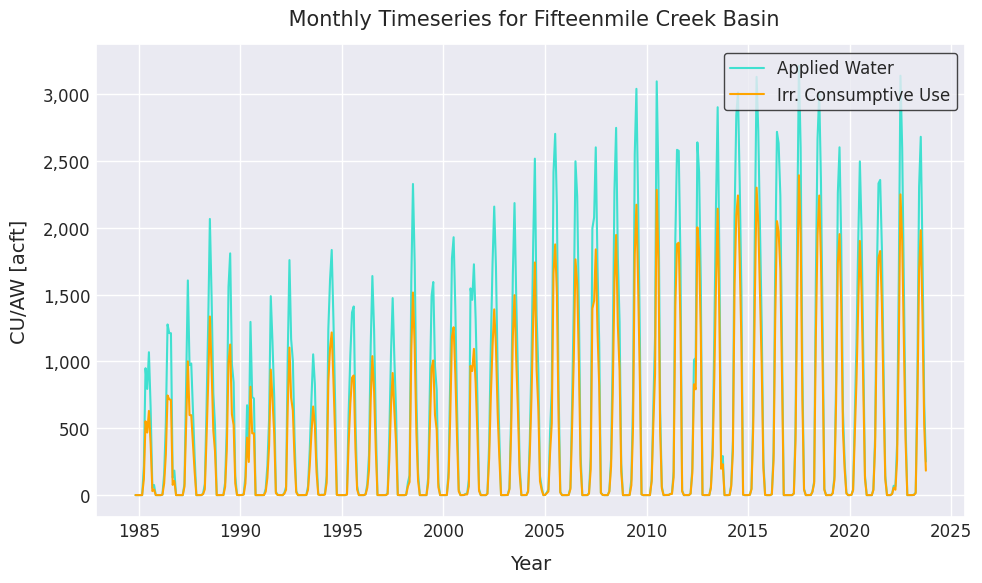

In [20]:

# read the geodatabase data
try:
    df_geo_monthly = pd.read_csv('/content/oregon_etcu_1985_2024_monthly_fifteen_eight_study_aoi.csv',
                                 index_col=0, parse_dates=True, usecols=['Date', 'ACRES', 'ET VOLUME (acft)', 'PRZ VOLUME (acft)', 'CU VOLUME (acft)', 'AW VOLUME (acft)'])
except Exception as e:
    print(e)

# filter to the overlapping time period with the geodatabase (1985-2023)
df_geo_monthly_filt = df_geo_monthly.loc['1984-11-01': '2023-10-01']


# compute annual (Nov-Oct) totals
df_an = (
    df_geo_monthly_filt
        .resample('YS-NOV')
        .agg({
            'ACRES': 'first',
            'ET VOLUME (acft)': 'sum',
            'PRZ VOLUME (acft)': 'sum',
            'CU VOLUME (acft)': 'sum',
            'AW VOLUME (acft)': 'sum'#,
            #'Total TID Supply (AF)': 'sum',
            #'Conveyance Loss Estimate (AF)': 'sum'
        })
)

# compute annual conveyance loss percentage
#df_an['Conveyance Loss %'] = (df_an['Conveyance Loss Estimate (AF)'] / df_an['Total TID Supply (AF)']) * 100

# plotting
df_mo = df_geo_monthly_filt.reset_index().rename(columns={'index':'Date'})

sns.set_theme(style="darkgrid")

# set up y-axis limits, ticks and unit label
#[et_min_mo, et_max_mo, et_int_mo] = [0, 14000, np.max(df_mo['Total TID Supply (AF)'].tolist())/10]

# x tick label format
datetick_format = "%y"

# extra dates specified for x axis limits
fir_mo = str(df_mo['Date'].iloc[0].date())
las_mo = str(df_mo['Date'].iloc[-1].date())
min_plot_mo = datetime.datetime.strptime(fir_mo, '%Y-%m-%d').date() - datetime.timedelta(days=90)
max_plot_mo = datetime.datetime.strptime(las_mo, '%Y-%m-%d').date() + datetime.timedelta(days=90)

# build plot
fig, (ax1) = plt.subplots(1, figsize=(10, 6))
ax1.set_title(' Monthly Timeseries for Fifteenmile Creek Basin', fontsize=15, pad=14)

# data vs. date
#sns.lineplot( x = "Date", y = "Total TID Supply (AF)",
             #color = 'blue', data = df_mo,
            # ax = ax1)
sns.lineplot( x = "Date", y = "AW VOLUME (acft)",
             color = 'turquoise', data = df_mo,
             ax = ax1)
sns.lineplot( x = "Date", y = "CU VOLUME (acft)",
             color = 'orange', data = df_mo,
             ax = ax1)

# legend items
#ax1.plot([],[], c='blue', label='Canal Diversion')
ax1.plot([],[], c='turquoise', label='Applied Water')
ax1.plot([],[], c='orange', label='Irr. Consumptive Use')

# legend and title
ax1.legend(loc=1, fontsize=12, ncol=1, edgecolor='k')

# y-axis aesthetics
ax1.set_ylabel('CU/AW [acft]', fontsize=14, labelpad=10) #Diversion/
#ax1.set_ylim([et_min_mo, et_max_mo])
ax1.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))

# x-axis aesthetics
ax1.set_xlabel('Year', fontsize=14, labelpad=10)
ax1.tick_params(axis='both', which='major', direction='in', width=1.3, length=4, pad=4, labelsize=12)

# formatting and layout
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "normal"
fig.tight_layout()

# export the plot to a PNG
plt.savefig('/content/fifteenmile_applied_water_monthly_timeseries_plot', dpi=400)

df_an.to_csv('/content/fifteenmile_applied_water_annual_timeseries.csv')

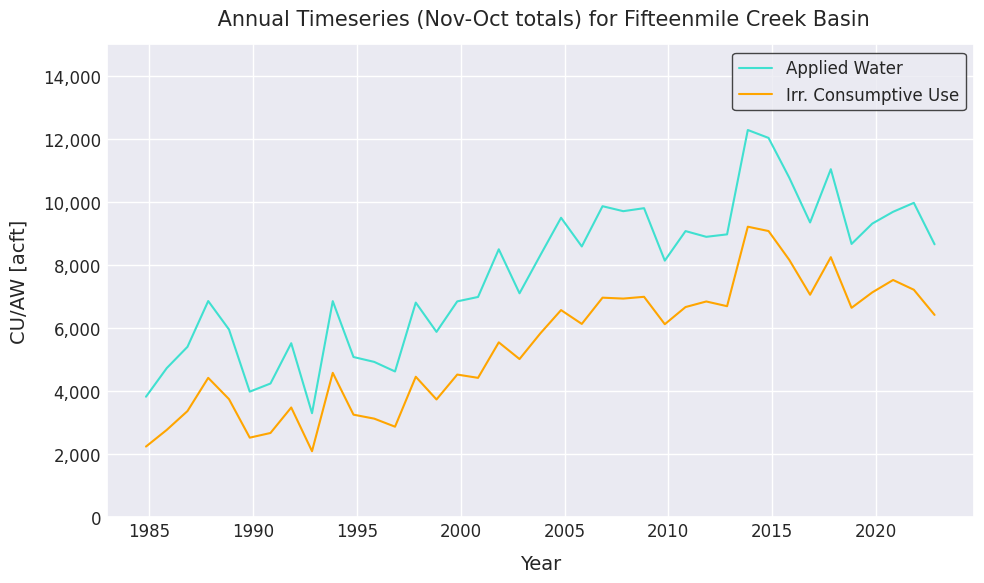

In [22]:
try:
    df_ann = pd.read_csv('/content/fifteenmile_applied_water_annual_timeseries.csv', index_col=0, parse_dates=True)
except Exception as e:
    print(e)

# extra dates specified for x axis limits
fir_an = str(df_ann.index[0].date())
las_an = str(df_ann.index[-1].date())
min_plot_an = datetime.datetime.strptime(fir_an, '%Y-%m-%d').date() - datetime.timedelta(days=90)
max_plot_an = datetime.datetime.strptime(las_an, '%Y-%m-%d').date() + datetime.timedelta(days=90)

# build plot
fig, (ax1) = plt.subplots(1, figsize=(10, 6))

ax1.set_title(f' Annual Timeseries (Nov-Oct totals) for Fifteenmile Creek Basin', fontsize=15, pad=14)

# data vs. date
df_ann = df_ann.reset_index().rename(columns={'index': 'Date'})

sns.lineplot( x = "Date", y = "AW VOLUME (acft)",
             color = 'turquoise', data = df_ann,
             ax = ax1)
sns.lineplot( x = "Date", y = "CU VOLUME (acft)",
             color = 'orange', data = df_ann,
             ax = ax1)

# legend items

ax1.plot([],[], c='turquoise', label='Applied Water')
ax1.plot([],[], c='orange', label='Irr. Consumptive Use')

# legend and title
ax1.legend(loc=1, fontsize=12, ncol=1, edgecolor='k')

# y-axis aesthetics
ax1.set_ylabel('CU/AW [acft]', fontsize=14, labelpad=10)
ax1.set_ylim([0, 15000])
ax1.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))

# x-axis aesthetics
ax1.set_xlabel('Year', fontsize=14, labelpad=10)
ax1.tick_params(axis='both', which='major', direction='in', width=1.3, length=4, pad=4, labelsize=12)

# formatting and layout
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "normal"
fig.tight_layout()

# export the plot to a PNG
plt.savefig('/content/fifteenmile_applied_water_annual_timeseries', dpi=400)

# Note: Below from here is not for fifteenmile creek basin
-----------------------------------------------------------

# 4. Compare applied water estimates to total diversions for Tumalo Irrigation District
> develop estimates of conveyance/canal losses for the irrigation district<br>
> must first use the '**upload**' spatial aggregation and '**monthly**' timestep parameters in step 3 before running the remainder of this code

## Read the Tumalo Irrigation District diversion data (daily) and convert it to a monthly timeseries for comparison with the monthly geodatabase applied water estimates

In [ ]:
try:
    # daily data provided in units of cubic feet per second (cfs), 1923-2022
    df_tid_daily = pd.read_excel('/content/OR_OWRD_OSU_training/data/TID_total_supply_est.xlsx', index_col=0, parse_dates=True, sheet_name='Sheet1')
except Exception as e:
    print(e)

# convert cfs to acre feet per day
df_tid_daily['Total TID Supply (AF)'] = df_tid_daily['Total TID Supply'] * 1.98346
df_tid_daily.drop(columns=['Total TID Supply'], inplace=True)

# resample the daily timestep to monthly totals
df_tid_monthly = df_tid_daily.resample('MS').sum()

# filter to the overlapping time period with the geodatabase (1985-2023 Nov-Oct, ~ caveat; ended in Sept 2024 so we cannot compare the full 2024 year)
df_tid_monthly_filt = df_tid_monthly.loc['1984-11-01': '2023-10-01']

# read the geodatabase data
try:
    df_geo_monthly = pd.read_csv('/content/oregon_etcu_1985_2024_monthly_tumalo_irrigation_district.csv',
                                 index_col=0, parse_dates=True, usecols=['Date', 'ACRES', 'ET VOLUME (acft)', 'PRZ VOLUME (acft)', 'CU VOLUME (acft)', 'AW VOLUME (acft)'])
except Exception as e:
    print(e)

# filter to the overlapping time period with the geodatabase (1985-2023)
df_geo_monthly_filt = df_geo_monthly.loc['1984-11-01': '2023-10-01']

# concatenate the two timeseries
df_mo = pd.concat([df_geo_monthly_filt, df_tid_monthly_filt], axis=1)

# compute the total conveyance loss by subtracting on-field applied water from total diversion
df_mo['Conveyance Loss Estimate (AF)'] = df_mo['Total TID Supply (AF)'] - df_mo['AW VOLUME (acft)']

# compute annual (Nov-Oct) totals
df_an = (
    df_mo
        .resample('YS-NOV')
        .agg({
            'ACRES': 'first',
            'ET VOLUME (acft)': 'sum',
            'PRZ VOLUME (acft)': 'sum',
            'CU VOLUME (acft)': 'sum',
            'AW VOLUME (acft)': 'sum',
            'Total TID Supply (AF)': 'sum',
            'Conveyance Loss Estimate (AF)': 'sum'
        })
)

# compute annual conveyance loss percentage
df_an['Conveyance Loss %'] = (df_an['Conveyance Loss Estimate (AF)'] / df_an['Total TID Supply (AF)']) * 100

# plotting
df_mo = df_mo.reset_index().rename(columns={'index':'Date'})

sns.set_theme(style="darkgrid")

# set up y-axis limits, ticks and unit label
[et_min_mo, et_max_mo, et_int_mo] = [0, 14000, np.max(df_mo['Total TID Supply (AF)'].tolist())/10]

# x tick label format
datetick_format = "%y"

# extra dates specified for x axis limits
fir_mo = str(df_mo['Date'].iloc[0].date())
las_mo = str(df_mo['Date'].iloc[-1].date())
min_plot_mo = datetime.datetime.strptime(fir_mo, '%Y-%m-%d').date() - datetime.timedelta(days=90)
max_plot_mo = datetime.datetime.strptime(las_mo, '%Y-%m-%d').date() + datetime.timedelta(days=90)

# build plot
fig, (ax1) = plt.subplots(1, figsize=(10, 6))
ax1.set_title(' Monthly Timeseries for Tumalo Irrigation District', fontsize=15, pad=14)

# data vs. date
sns.lineplot( x = "Date", y = "Total TID Supply (AF)",
             color = 'blue', data = df_mo,
             ax = ax1)
sns.lineplot( x = "Date", y = "AW VOLUME (acft)",
             color = 'turquoise', data = df_mo,
             ax = ax1)
sns.lineplot( x = "Date", y = "CU VOLUME (acft)",
             color = 'orange', data = df_mo,
             ax = ax1)

# legend items
ax1.plot([],[], c='blue', label='Canal Diversion')
ax1.plot([],[], c='turquoise', label='Applied Water')
ax1.plot([],[], c='orange', label='Irr. Consumptive Use')

# legend and title
ax1.legend(loc=1, fontsize=12, ncol=1, edgecolor='k')

# y-axis aesthetics
ax1.set_ylabel('Diversion/CU/AW [acft]', fontsize=14, labelpad=10)
ax1.set_ylim([et_min_mo, et_max_mo])
ax1.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))

# x-axis aesthetics
ax1.set_xlabel('Year', fontsize=14, labelpad=10)
ax1.tick_params(axis='both', which='major', direction='in', width=1.3, length=4, pad=4, labelsize=12)

# formatting and layout
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "normal"
fig.tight_layout()

# export the plot to a PNG
plt.savefig('/content/tid_diversion_applied_water_joined_monthly_timeseries_plot', dpi=400)

df_an.to_csv('/content/tid_diversion_applied_water_joined_annual_timeseries.csv')

## Annual timeseries plot
> shifted water year Nov-Oct totals, following geodatabase structure

In [ ]:
try:
    df_ann = pd.read_csv('/content/tid_diversion_applied_water_joined_annual_timeseries.csv', index_col=0, parse_dates=True)
except Exception as e:
    print(e)

# extra dates specified for x axis limits
fir_an = str(df_ann.index[0].date())
las_an = str(df_ann.index[-1].date())
min_plot_an = datetime.datetime.strptime(fir_an, '%Y-%m-%d').date() - datetime.timedelta(days=90)
max_plot_an = datetime.datetime.strptime(las_an, '%Y-%m-%d').date() + datetime.timedelta(days=90)

# build plot
fig, (ax1) = plt.subplots(1, figsize=(10, 6))

ax1.set_title(f' Annual Timeseries (Nov-Oct totals) for Tumalo Irrigation District', fontsize=15, pad=14)

# data vs. date
df_ann = df_ann.reset_index().rename(columns={'index': 'Date'})
sns.lineplot( x = "Date", y = "Total TID Supply (AF)",
             color = 'blue', data = df_ann,
             ax = ax1)
sns.lineplot( x = "Date", y = "AW VOLUME (acft)",
             color = 'turquoise', data = df_ann,
             ax = ax1)
sns.lineplot( x = "Date", y = "CU VOLUME (acft)",
             color = 'orange', data = df_ann,
             ax = ax1)

# legend items
ax1.plot([],[], c='blue', label='Canal Diversion')
ax1.plot([],[], c='turquoise', label='Applied Water')
ax1.plot([],[], c='orange', label='Irr. Consumptive Use')

# legend and title
ax1.legend(loc=1, fontsize=12, ncol=1, edgecolor='k')

# y-axis aesthetics
ax1.set_ylabel('Diversion/CU/AW [acft]', fontsize=14, labelpad=10)
ax1.set_ylim([0, 80000])
ax1.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))

# x-axis aesthetics
ax1.set_xlabel('Year', fontsize=14, labelpad=10)
ax1.tick_params(axis='both', which='major', direction='in', width=1.3, length=4, pad=4, labelsize=12)

# formatting and layout
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "normal"
fig.tight_layout()

# export the plot to a PNG
plt.savefig('/content/tid_diversion_applied_water_joined_annual_timeseries', dpi=400)


## Annual Loss Percentage plot

In [ ]:
try:
    df_loss = pd.read_csv('/content/tid_diversion_applied_water_joined_annual_timeseries.csv', index_col=0, parse_dates=True)
except Exception as e:
    print(e)

# extra dates specified for x axis limits
fir_mo = str(df_loss.index[0].date())
las_mo = str(df_loss.index[-1].date())
min_plot_mo = datetime.datetime.strptime(fir_mo, '%Y-%m-%d').date() - datetime.timedelta(days=90)
max_plot_mo = datetime.datetime.strptime(las_mo, '%Y-%m-%d').date() + datetime.timedelta(days=90)

# build plot
fig, (ax1) = plt.subplots(1, figsize=(10, 7))
ax1.set_title(' Annual Conveyance Losses for Tumalo Irrigation District Diversions', fontsize=14, pad=15)

# data vs. date
df_loss = df_loss.reset_index().rename(columns={'index': 'Date'})
sns.lineplot( x = "Date", y = "Conveyance Loss %",
             color = 'green', data = df_loss,
             ax = ax1)

# legend items
ax1.plot([],[], c='green', label='Conveyance Loss %')

# legend and title
ax1.legend(loc=1, fontsize=12, ncol=1, edgecolor='k')

# y-axis aesthetics
ax1.set_ylabel('Conveyance Loss Estimate [%]', fontsize=14, labelpad=10)
ax1.set_ylim([0, 100])

# x-axis aesthetics
ax1.set_xlabel('Year', fontsize=14, labelpad=10)
ax1.tick_params(axis='both', which='major', direction='in', width=1.3, length=4, pad=4, labelsize=12)

# formatting and layout
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "normal"
fig.tight_layout()

# export the plot to a PNG
plt.savefig('/content/tid_diversion_conveyance_losses_annual_timeseries_plot', dpi=400)

# Comparisons with **[Gannett and others (2001)](https://pubs.usgs.gov/wri/wri004162/)** Ground-Water Hydrology of the Upper Deschutes Basin, Oregon, adapted from **Table 4**

## 1994 Gannett and others estimates:
| A | B | C | D | E | F | G |
| --- | --- | --- | --- | --- | --- | --- |
| Canal diversions (ac-ft) | Irrigated area (ac) | Mean crop water requirement (ft/yr) | Crop water needs (ac-ft) | Mean irrigation efficiency (%) | Estimated deliveries (D / E) | Canal losses (A - F) |
| 42,600 | 4,890 | 2.31 | 11,300 | 0.60 | 18,830 | 23,770 |

<br>

## 1994 (Nov-Oct) OWRD - DRI Consumptive Use Geodatabase estimates and canal diversions provided by OWRD:
| A | B | C | D | E | F | G |
| --- | --- | --- | --- | --- | --- | --- |
| Canal diversions (ac-ft) | Irrigated area (ac) | Mean irrig. consumptive use (ft/yr) | Crop water use (ac-ft) | Mean irrigation efficiency (%) | Estimated deliveries | Canal losses (A - F) |
| 55,823 | 3,980 | 1.16 | 4,633 | 0.75 | 6,178 | 49,645 |

<br>

### **NOTES**:
* Gannett and other's crop water requirement estimates are based on [Cuenca and others (1992)](https://extension.oregonstate.edu/sites/default/files/documents/em8530.pdf) Blaney-Criddle Reference ET and Crop Coefficient approach
* Gannett and other's irrigated area only includes high and medium water-use crops
* Gannett and other's estimated conveyance losses for 1994 May-Sept, not a full year
* OWRD - DRI geodatabase estimates consider actual crop water-use, not potential
* OWRD - DRI geodatabase estimates are for Nov-Oct totals, not calendar year; not an apples-to-apples comparison
* OWRD - DRI geodatabase estimates could be overestimating average irrigation efficiency
* OWRD - DRI geodatabase estimates could be underestimating total irrigated acreage

<br>

### **TAKEAWAYS**:
* Review of irrigation status for fields is required for this type of application, determining actual places of use is crucial for volumetric comparisons and assessments of conveyance losses
* Despite the decreasing trend in canal diversions, there is a slightly increasing trend in total applied water volume, indicating that canal losses are being minimized with improved infrastructure.